In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [93]:
import os
import sys
import random
import warnings


import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.losses import binary_crossentropy

In [3]:
!unzip -q /content/drive/My\ Drive/Colab\ Notebooks/DS_test_quantum/dataset.zip

In [94]:
ls

 drive/                                stage1_sample_submission.csv/
 model_classic_kaggle_unet.h5          stage1_solution.csv/
'model_classic_unet  _0647 _9001.h5'   stage1_test/
 model_classic_unet.h5                 stage1_train/
 model_unet+resnet50.h5                stage1_train_labels.csv/
 requirements.txt                      stage2_sample_submission_final.csv/
 sample_data/                          stage2_test_final/


In [5]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '../content/stage1_train/'
TEST_PATH = '../content/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [106]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get and resize train images and masks

In [7]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask




Getting and resizing train images and masks ... 


100%|██████████| 670/670 [06:38<00:00,  1.68it/s]


In [8]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


100%|██████████| 65/65 [00:02<00:00, 29.22it/s]


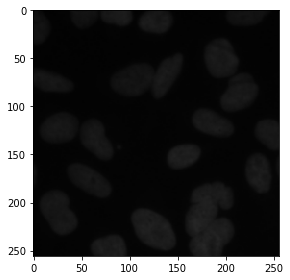

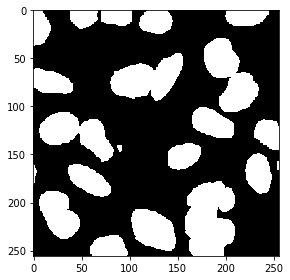

In [9]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [10]:
X_train.shape

(670, 256, 256, 3)

# Metric


In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

# Create model classic U-Nets

In [81]:
inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)
conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)
pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)
conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)
pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)
conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)
pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)
conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)
pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])
conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)
conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])
conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)
conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])
conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)
conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)

up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)
model.compile(optimizer='adam', loss=binary_crossentropy, metrics = [dice_coef, 'acc', 'mse'])
# model.summary()

In [82]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("model_classic_unet.h5", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

epochs = 50
batch_size = 16

results = model.fit(X_train, Y_train, validation_split=0.1,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],shuffle=True)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 1.1087 - dice_coef: 0.2554 - acc: 0.8255 - mse: 0.1813
Epoch 00001: val_loss improved from inf to 0.24399, saving model to model_classic_unet.h5
38/38 [==============================] - 6s 155ms/step - loss: 1.1087 - dice_coef: 0.2554 - acc: 0.8255 - mse: 0.1813 - val_loss: 0.2440 - val_dice_coef: 0.5459 - val_acc: 0.9028 - val_mse: 0.0725
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.1813 - dice_coef: 0.6477 - acc: 0.9252 - mse: 0.0532
Epoch 00002: val_loss improved from 0.24399 to 0.13606, saving model to model_classic_unet.h5
38/38 [==============================] - 6s 148ms/step - loss: 0.1813 - dice_coef: 0.6477 - acc: 0.9252 - mse: 0.0532 - val_loss: 0.1361 - val_dice_coef: 0.7292 - val_acc: 0.9465 - val_mse: 0.0388
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.1168 - dice_coef: 0.7778 - acc: 0.9564 - mse: 0.0329
Epoch 00003: val_loss improved from 0.13606 to 0.1112

# Predict data model #1 classic Unet

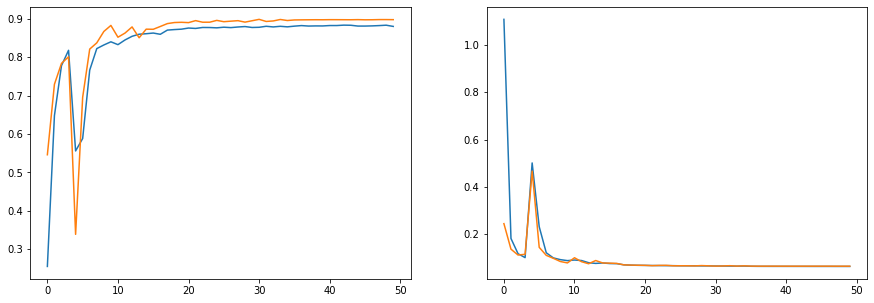

In [83]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_acc.plot(results.epoch, results.history["loss"], label="Loss")
ax_acc.plot(results.epoch, results.history["val_loss"], label="Validation loss")
ax_loss.plot(results.epoch, results.history["dice_coef"], label="dice_coef")
ax_loss.plot(results.epoch, results.history["val_dice_coef"], label="val_dice_coef")

Saved model: val_loss: 0.0641 - val_dice_coef: 0.8973 

In [74]:
model = load_model('/content/model_classic_unet.h5', custom_objects={'dice_coef': dice_coef})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

3/3 [==============================] - 0s 111ms/step


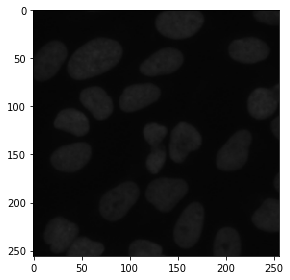

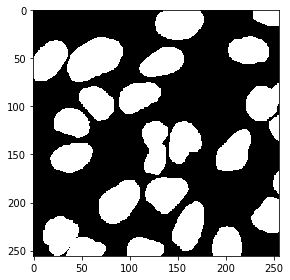

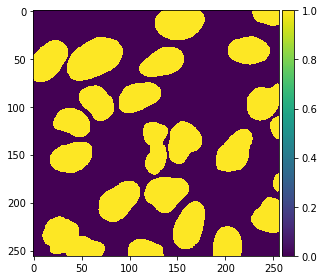

In [84]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

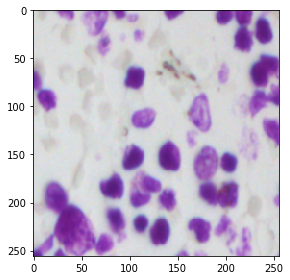

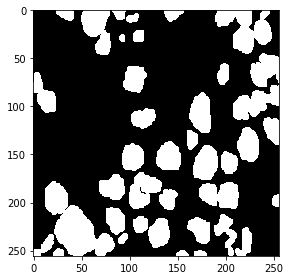

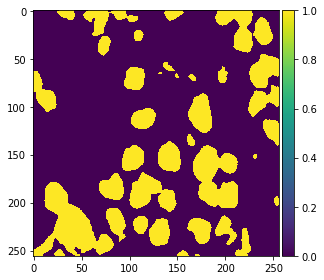

In [76]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [79]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [80]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('predict test classic unet.csv', index=False)

# Create model U-Nets with ResNet Encoders

In [22]:
base_model = ResNet50(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), include_top=False)
base_out = base_model.output

In [23]:
base_out

<tf.Tensor 'conv5_block3_out/Relu_1:0' shape=(None, 8, 8, 2048) dtype=float32>

In [24]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [25]:
conv1 = base_model.get_layer('conv1_relu').output #128, 128, 64
conv2 = base_model.get_layer('conv2_block1_out').output #(None, 64, 64, 256)
conv3 = base_model.get_layer('conv3_block3_out').output #(None, 32, 32, 512)
conv4 = base_model.get_layer('conv4_block6_out').output #(None, 16, 16, 1024) 
conv5 = base_model.get_layer('conv5_block3_out').output #(None, 8, 8, 2048) 

inp = base_model.get_layer(base_model.layers[0].name).output 

In [26]:
#2048-1024-512 - 256 -64


up1 = Conv2DTranspose(2048, (2, 2), strides=(2, 2), padding='same') (conv5)
conc_1 = Concatenate()([up1, conv4]) #2048+1024
conv_conc_1 = Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conc_1)
conv_conc_1 = Dropout(0.1) (conv_conc_1)

up2 = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same') (conv_conc_1)
conc_2 = Concatenate()([up2, conv3]) #1024+512
conv_conc_2 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conc_2)
conv_conc_2 = Dropout(0.1) (conv_conc_2)

up3 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (conv_conc_2)
conc_3 = Concatenate()([up3, conv2]) #512+256
conv_conc_3 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conc_3)
conv_conc_3 = Dropout(0.1) (conv_conc_3)

up4 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (conv_conc_3)
conc_4 = Concatenate()([up4, conv1]) #256 + 64
conv_conc_4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conc_4)
conv_conc_4 = Dropout(0.1) (conv_conc_4)

up5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv_conc_4)#256, 256, 32
conv_conc_5 = Conv2D(1, (1, 1), padding='same')(up5)
conv_conc_5 = Activation('sigmoid')(conv_conc_5)

In [27]:
from keras.losses import binary_crossentropy
model = Model(inputs=base_model.input, outputs=conv_conc_5)
model.compile(optimizer='adam', loss= binary_crossentropy, metrics = [dice_coef, 'acc', 'mse']) # I use binary_crossentropy as the loss func because, dice coef loss gave worse results
# model.summary()

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("model_unet_resnet.h5", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

epochs = 50
batch_size = 16

results = model.fit(X_train, Y_train, validation_split=0.1,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],shuffle=True)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.6540 - dice_coef: 0.2640 - acc: 0.8153 - mse: 0.1447
Epoch 00001: val_loss improved from inf to 2574.57275, saving model to reduce_lr + 2048 + 512.h5
38/38 [==============================] - 33s 873ms/step - loss: 0.6540 - dice_coef: 0.2640 - acc: 0.8153 - mse: 0.1447 - val_loss: 2574.5728 - val_dice_coef: 0.1165 - val_acc: 0.7745 - val_mse: 0.2240
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.1411 - dice_coef: 0.8124 - acc: 0.9407 - mse: 0.0428
Epoch 00002: val_loss improved from 2574.57275 to 77.42375, saving model to reduce_lr + 2048 + 512.h5
38/38 [==============================] - 28s 748ms/step - loss: 0.1411 - dice_coef: 0.8124 - acc: 0.9407 - mse: 0.0428 - val_loss: 77.4238 - val_dice_coef: 0.3068 - val_acc: 0.8505 - val_mse: 0.1296
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.1021 - dice_coef: 0.8694 - acc: 0.9589 - mse: 0.0302
Epoch 00003: val_loss improved f

# Predict data model #2 Unet+ Resnet

Saved model:  val_loss: 0.0594 - val_dice_coef: 0.9349

In [70]:
model = load_model('/content/drive/My Drive/Colab Notebooks/DS_test_quantum/model_unet_resnet.h5', custom_objects={'dice_coef': dice_coef})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

3/3 [==============================] - 0s 148ms/step


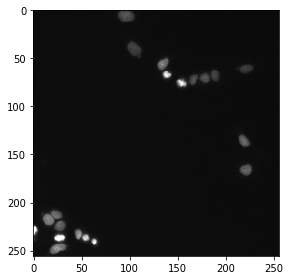

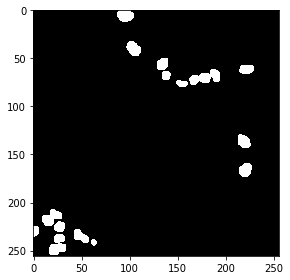

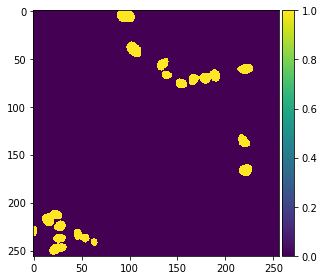

In [71]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

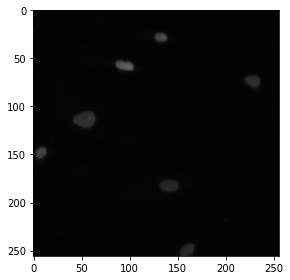

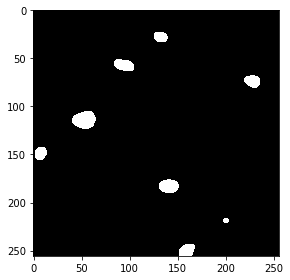

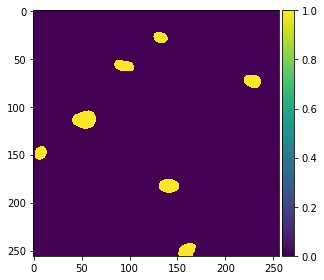

In [72]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('Predict test unet + resnet.csv', index=False)

In [87]:
!pip3 freeze > requirements.txt